# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.getcwd()

'/Users/christellejoseph/code/Cyber_Tools/IDS'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from collections import Counter

In [5]:
csv_path = '/Users/christellejoseph/code/Cyber_Tools/IDS/data'
file_dir = os.listdir(csv_path)

In [6]:
csv_files = []
for file in file_dir:
    modified_file = file.replace('-WorkingHours', '').replace('-workingHours', '').replace(
                                        '-Afternoon', '').replace('-Morning', '').replace('.pcap_ISCX.csv', '')
    csv_files.append(modified_file)

# Merging: Dictionary Structure

In [7]:
data = {}

for name, filename in sorted(zip(csv_files, file_dir)):
    data[name] = pd.read_csv(os.path.join(csv_path, filename))

In [8]:
data['Monday'].head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Merging: Single DataFrame

In [9]:
all_data = pd.concat([pd.read_csv(os.path.join(csv_path, file)) for file in file_dir], ignore_index=True)

In [10]:
all_data.shape

(2830743, 79)

In [11]:
all_data.columns = all_data.columns.str.strip()

In [12]:
cat_value_count = all_data['Label'].value_counts()

In [13]:
all_data['Label'] = all_data['Label'].str.replace('�', '-', regex=False)


In [14]:
# all_data.to_csv('combined_df.csv', index=False)

In [15]:
# all_data = all_data.drop_duplicates()

In [16]:
all_data.shape

(2830743, 79)

In [17]:
# all_data.isna().sum().sort_values(ascending=False)

In [18]:
all_data = all_data.dropna(axis=1, how='any')

# Category Visualization

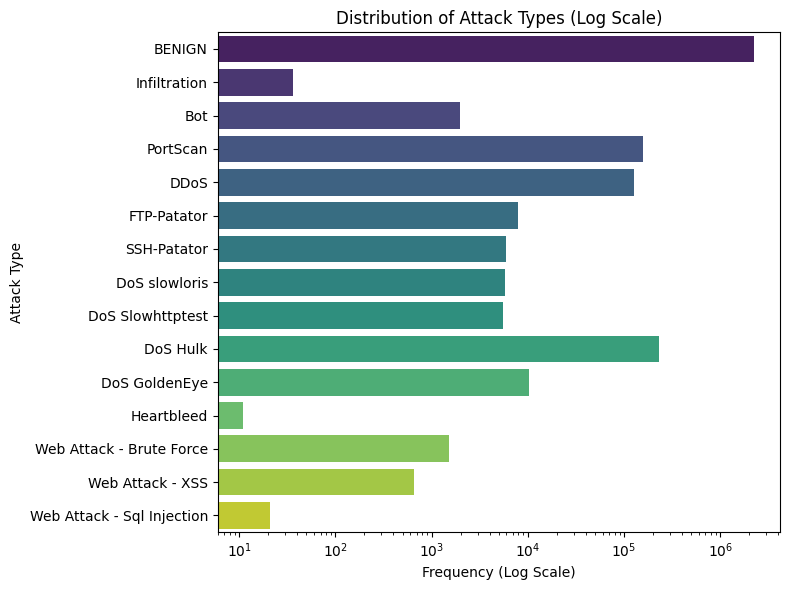

In [56]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Label', data=all_data, palette='viridis')

# Set the scale of x-axis to log to better visualize the differences
ax.set_xscale('log')
plt.title('Distribution of Attack Types (Log Scale)')
plt.xlabel('Frequency (Log Scale)')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# Encoder

In [20]:
label_encoder = LabelEncoder()
all_data['EncodedLabel'] = label_encoder.fit_transform(all_data['Label'])
#Get the mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Balancing Dataset

In [21]:
all_data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,EncodedLabel
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06,1.064417e+00
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07,2.576420e+00
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08,1.400000e+01


In [22]:
#Solves - ValueError: Input X contains infinity or a value too large

all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data.dropna(inplace=True)

In [48]:
X = all_data.select_dtypes(exclude='object').drop(columns = 'EncodedLabel')
y = all_data['EncodedLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [25]:
sample_size = 10000
X_sample = X_res.sample(n=sample_size, random_state=42)
y_sample = y_res.loc[X_sample.index]

In [105]:
y_df = pd.DataFrame(y_sample).sort_values(by='EncodedLabel', ascending=False)

y_df['EncodedLabel'].value_counts()

1     700
4     695
10    694
0     691
9     671
13    670
3     667
11    666
7     664
12    652
6     652
14    649
8     646
5     646
2     637
Name: EncodedLabel, dtype: int64

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 800x600 with 0 Axes>

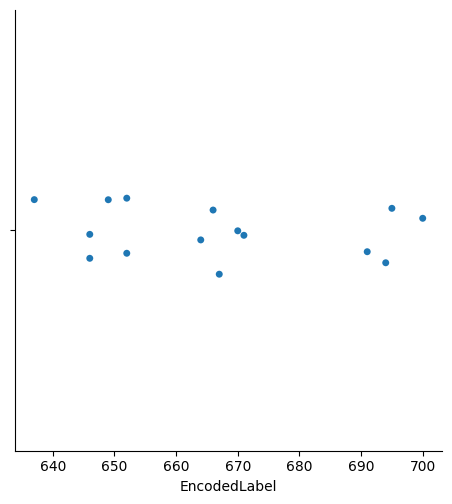

# Feature Selection & Engineering

In [108]:
model = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_sample, y_sample)

print("Optimal number of features : %d" % rfecv.n_features_)


Optimal number of features : 52


In [134]:
X_reduced = rfecv.transform(X_sample)

In [139]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Assume X_reduced and y are your dataset and target variable after RFECV
model = RandomForestClassifier()
model.fit(X_reduced, y_sample)

selector = SelectFromModel(model, threshold='median')  # Adjust threshold as needed
X_selected = selector.fit_transform(X_reduced, y_sample)

print("Shape of X after further reduction:", X_selected.shape)


Shape of X after further reduction: (10000, 26)


In [140]:
X_selected

array([[8.000000e+01, 0.000000e+00, 0.000000e+00, ..., 2.920000e+04,
        2.896000e+04, 3.200000e+01],
       [4.440000e+02, 1.058300e+04, 7.742771e+06, ..., 1.251300e+04,
        2.350000e+02, 3.200000e+01],
       [4.430000e+02, 8.710000e+02, 6.462400e+04, ..., 6.553500e+04,
        1.220000e+02, 3.200000e+01],
       ...,
       [8.000000e+01, 2.541000e+03, 6.000000e+00, ..., 2.920000e+04,
        0.000000e+00, 3.200000e+01],
       [7.200000e+03, 0.000000e+00, 6.000000e+00, ..., 2.920000e+04,
        0.000000e+00, 4.000000e+01],
       [4.324000e+03, 6.000000e+00, 6.000000e+00, ..., 2.370000e+02,
        2.560000e+02, 2.000000e+01]])

In [124]:
from sklearn.feature_selection import RFE

model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_sample, y_sample)
selected_features = rfe.support_
selected_features.shape

In [135]:
feature_names = X_sample.columns
selected_feature_names = feature_names[selected_features_1]